# Comparison of Different Taxonomic Classification Approaches

This notebook compares the performance and results of different taxonomic classification methods:

1. **Manual Curation** - Ground truth from expert manual annotation
2. **Palmprint Results** - Palmprint-based classification
3. **DIAMOND** - Traditional BLAST-like sequence alignment tool
4. **MEGAN6** - Metagenome analysis tool
5. **Model Predictions** - Machine learning model predictions

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os

# Add utils to path
sys.path.append('../scripts')
from utils import *

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

## Data Loading and Preprocessing

Load results from all classification approaches for comparison.

In [2]:
df = pd.read_excel('/home/tobamo/analize/project-tobamo/analysis/data/domain_sci_input/Tobamo - tabela za tobamo kontige - kategorije_2025-09-23.xlsx', header=0, skiprows=[1])

In [3]:
# Define data paths
results_dir = os.makedirs('results/comparison_study', exist_ok=True)

ground_truth = pd.read_excel('/home/tobamo/analize/project-tobamo/analysis/data/domain_sci_input/ground_truth_final_added_categories.xlsx')
diamond_megan_results = pd.read_csv('/home/tobamo/analize/project-tobamo/results/megan6_results_combined_add_nr_taxa.csv')
model_predictions = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/snakemake/predictions/contig_predictions.csv')
palmprint = SeqIO.to_dict(SeqIO.parse('/home/tobamo/analize/project-tobamo/analysis/palmprint/results/palmscan/palmscan_pp_find0.fa','fasta'))

## Method 1: Manual Curation (Ground Truth)

Expert manual annotations serving as ground truth for comparison.

### Key Features:
- High accuracy from expert knowledge
- Time-intensive process
- Serves as benchmark for other methods

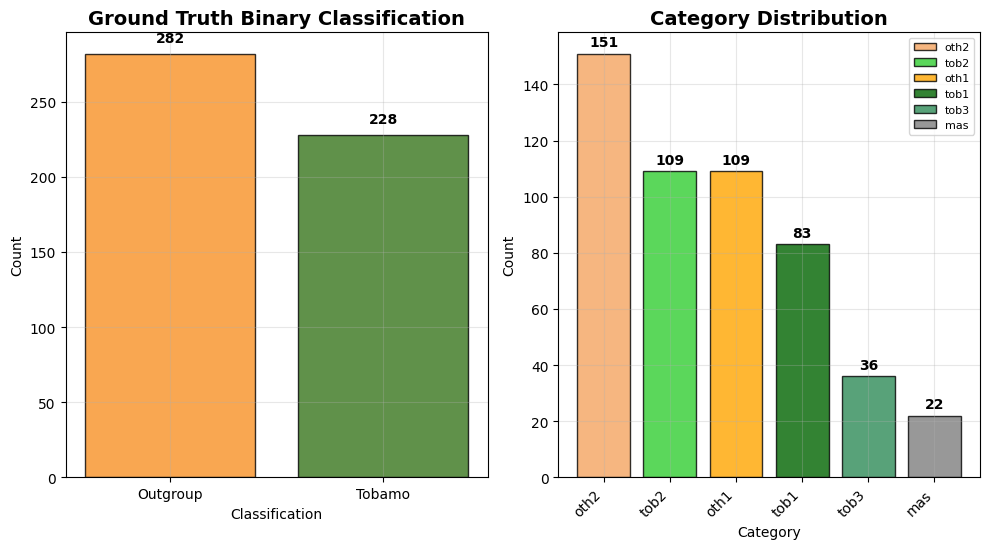

=== GROUND TRUTH DATASET SUMMARY ===
Total samples: 510
Available columns: ['contig_name', 'ground_truth', 'category_old', 'category']

Ground Truth binary classification:
  Outgroup (0): 282 (55.3%)
  Tobamo (1): 228 (44.7%)

Category distribution:
  oth2: 151 (29.6%) - Sequences belonging to other viruses
  tob2: 109 (21.4%) - Tobamoviral sequences - novel
  oth1: 109 (21.4%) - Sequences belonging/related to other members of Virgaviridae
  tob1: 83 (16.3%) - Tobamoviral sequences - known
  tob3: 36 (7.1%) - Tobamoviral sequences - difficult to assign
  mas: 22 (4.3%) - Misassembled sequences


In [4]:
# Ground Truth Distribution Analysis

# Define the category palette
category_palette = {
    'tob1': "#006400",   # dark green
    'tob2': "#32CD32",   # lime green
    'tob3': "#2E8B57",   # sea green
    'oth1': "#FFA500",   # orange
    'oth2': "#F4A460",   # sandy brown
    'oth3': "#cd853f",   # peru
    'mas': "#7f7f7f",   # grey
}

# Define category descriptions
category_map = {
    'tob1': "Tobamoviral sequences - known",
    'tob2': "Tobamoviral sequences - novel",
    'tob3': "Tobamoviral sequences - difficult to assign",
    'oth1': "Sequences belonging/related to other members of Virgaviridae",
    'oth2': "Sequences belonging to other viruses",
    'oth3': "Sequences belonging to other viruses - difficult to assign",
    'mas': "Misassembled sequences"
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.6))

# Plot 1: ground_truth distribution (binary classification)
if 'ground_truth' in ground_truth.columns:
    # Create binary labels
    binary_labels = {0.0: 'Outgroup', 1.0: 'Tobamo'}
    binary_colors = {0.0: '#f89125', 1.0: '#38761d'}  # Red for outgroup, teal for tobamo
    
    ground_truth_counts = ground_truth['ground_truth'].value_counts().sort_index()
    
    # Create bars with custom colors
    bars = []
    for value in ground_truth_counts.index:
        color = binary_colors.get(value, 'gray')
        label = binary_labels.get(value, f'Unknown ({value})')
        bar = ax1.bar(label, ground_truth_counts[value], 
                     color=color, edgecolor='black', alpha=0.8)
        bars.extend(bar)
    
    ax1.set_title('Ground Truth Binary Classification', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Classification')
    ax1.set_ylabel('Count')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (value, count) in enumerate(ground_truth_counts.items()):
        ax1.text(i, count + max(ground_truth_counts.values) * 0.02, str(count), 
                ha='center', va='bottom', fontweight='bold')
else:
    ax1.text(0.5, 0.5, 'ground_truth column\nnot found', 
             ha='center', va='center', transform=ax1.transAxes, 
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
    ax1.set_title('Ground Truth Binary Classification', fontsize=14, fontweight='bold')

# Plot 2: category distribution with custom color palette
if 'category' in ground_truth.columns:
    category_counts = ground_truth['category'].value_counts()
    
    # Create bars with category-specific colors
    colors = [category_palette.get(cat, '#CCCCCC') for cat in category_counts.index]
    
    bars = ax2.bar(range(len(category_counts)), category_counts.values, 
                   color=colors, edgecolor='black', alpha=0.8)
    
    ax2.set_title('Category Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Category')
    ax2.set_ylabel('Count')
    ax2.set_xticks(range(len(category_counts)))
    ax2.set_xticklabels(category_counts.index, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(category_counts.values):
        ax2.text(i, v + max(category_counts.values) * 0.01, str(v), 
                ha='center', va='bottom', fontweight='bold')
        
    # Add legend for categories
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=category_palette.get(cat, '#CCCCCC'), 
                                   edgecolor='black', alpha=0.8, label=f'{cat}')
                      for cat in category_counts.index if cat in category_palette]
    if legend_elements:
        ax2.legend(handles=legend_elements, loc='upper right', fontsize=8)
        
else:
    ax2.text(0.5, 0.5, 'category column\nnot found', 
             ha='center', va='center', transform=ax2.transAxes, 
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
    ax2.set_title('Category Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== GROUND TRUTH DATASET SUMMARY ===")
print(f"Total samples: {len(ground_truth)}")
print(f"Available columns: {list(ground_truth.columns)}")

if 'ground_truth' in ground_truth.columns:
    print(f"\nGround Truth binary classification:")
    for value, count in ground_truth['ground_truth'].value_counts().sort_index().items():
        class_name = 'Outgroup' if value == 0.0 else 'Tobamo' if value == 1.0 else f'Unknown ({value})'
        print(f"  {class_name} ({value}): {count} ({count/len(ground_truth)*100:.1f}%)")

if 'category' in ground_truth.columns:
    print(f"\nCategory distribution:")
    for category, count in ground_truth['category'].value_counts().items():
        description = category_map.get(category, "Unknown category")
        print(f"  {category}: {count} ({count/len(ground_truth)*100:.1f}%) - {description}")

## Method 1: PALMPRINT

In [5]:
palmprint_positive_contigs = ['_'.join(k.split('_')[:-1]) for k in palmprint.keys()]

In [6]:
df['palmprint'] = np.where(df['contig_id'].isin(palmprint_positive_contigs), 1, 0)
tobamo_palmprints = df[(df['palmprint'] == 1) & (df['ground_truth_category'].isin(['tob1','tob2','tob3']))]

print(f"{len(tobamo_palmprints)} actual tobamo out of {df[df['ground_truth_category'].isin(['tob1','tob2','tob3'])].shape[0]} assigned tobamo, which is ({len(tobamo_palmprints) / df[df['ground_truth_category'].isin(['tob1','tob2','tob3'])].shape[0] * 100:.1f}%) total assigned tobamo")

40 actual tobamo out of 228 assigned tobamo, which is (17.5%) total assigned tobamo


## Method 2: DIAMOND Classification

Traditional sequence alignment-based classification using DIAMOND.

### Key Features:
- Fast BLAST-like sequence aligner
- Well-established and widely used
- Provides alignment scores and e-values

In [7]:
nt_tobamo = df[df['first_diamond_blastx_hit_name'].str.contains('tobamovirus', case=False, na=False)]
nt_tobamo_correct = df[(df['first_diamond_blastx_hit_name'].str.contains('tobamovirus', case=False, na=False)) & (df['ground_truth_category'].isin(['tob1','tob2','tob3']))]
print(f"{df[(df['first_diamond_blastx_hit_name'].str.contains('tobamovirus', case=False, na=False)) & (df['ground_truth_category'].isin(['tob1','tob2','tob3']))].shape[0]} actual tobamo out of {df[df['ground_truth_category'].isin(['tob1','tob2','tob3'])].shape[0]} assigned tobamo, which is ({df[(df['first_diamond_blastx_hit_name'].str.contains('tobamovirus', case=False, na=False)) & (df['ground_truth_category'].isin(['tob1','tob2','tob3']))].shape[0] / df[df['ground_truth_category'].isin(['tob1','tob2','tob3'])].shape[0] * 100:.1f}%) total assigned tobamo")

186 actual tobamo out of 228 assigned tobamo, which is (81.6%) total assigned tobamo


## Method 3: MEGAN6 Classification

Metagenome analysis using MEGAN6 for taxonomic assignment.

### Key Features:
- Specialized for metagenome analysis
- Uses LCA (Lowest Common Ancestor) algorithm
- Integrates multiple alignment results

In [8]:
# MEGAN6 results analysis
# Extract MEGAN6 specific results from the combined file

diamond_megan_results.drop_duplicates(subset='qseqid', keep='first')
megan_tax_mapper = diamond_megan_results.set_index('qseqid')['megan_tax'].to_dict()
df['megan_tax'] = df['contig_id'].map(megan_tax_mapper)

megan_tobamo = df[(df['megan_tax'].str.contains('tobamovirus', case=False, na=False))]
megan_tobamo_correct = df[(df['megan_tax'].str.contains('tobamovirus', case=False, na=False)) & (df['ground_truth_category'].isin(['tob1','tob2','tob3']))]
print(f"{megan_tobamo.shape[0]} actual tobamo out of {df['ground_truth_category'].isin(['tob1','tob2','tob3']).sum()} assigned tobamo, which is ({megan_tobamo.shape[0] / df['ground_truth_category'].isin(['tob1','tob2','tob3']).sum() * 100:.1f}%) total assigned tobamo")

215 actual tobamo out of 228 assigned tobamo, which is (94.3%) total assigned tobamo


## Method 4: Machine Learning Model Predictions

Analysis of ML model-based taxonomic predictions.

### Key Features:
- Trained on curated datasets
- Can learn complex patterns in sequence data
- Provides confidence scores for predictions

In [9]:
model_tobamo = df[(df['model_prediction'] == 1) & (df['ground_truth_category'].isin(['tob1','tob2','tob3']))]
print(f"{model_tobamo.shape[0]} actual tobamo out of {df['ground_truth_category'].isin(['tob1','tob2','tob3']).sum()} assigned tobamo, which is ({model_tobamo.shape[0] / df['ground_truth_category'].isin(['tob1','tob2','tob3']).sum() * 100:.1f}%) total assigned tobamo")

212 actual tobamo out of 228 assigned tobamo, which is (93.0%) total assigned tobamo


### COMBINE METHODS

In [10]:
gt = ground_truth.drop(columns=['category_old'])
gt['palmprint_present'] = np.where(gt['contig_name'].isin(palmprint_positive_contigs), 1, 0)
gt['palmprint_tobamovirus_correct'] = np.where((gt['palmprint_present']) & (gt['ground_truth'] == 1), 1, 0)
gt['palmprint_tobamovirus_false'] = np.where((gt['palmprint_present']) & (gt['ground_truth'] == 1) &(gt['ground_truth'] == 0), 1, 0)
gt['diamond_nr_tobamovirus'] = np.where(gt['contig_name'].isin(nt_tobamo['contig_id']), 1, 0)
gt['diamond_nr_tobamovirus_correct'] = np.where((gt['diamond_nr_tobamovirus']) & (gt['ground_truth'] == 1), 1, 0)
gt['diamond_nr_tobamovirus_false'] = np.where((gt['diamond_nr_tobamovirus']) & (gt['ground_truth'] == 0), 1, 0)
gt['megan_tobamovirus'] = np.where(gt['contig_name'].isin(megan_tobamo['contig_id']), 1, 0)
gt['megan_tobamovirus_correct'] = np.where((gt['megan_tobamovirus']) & (gt['ground_truth'] == 1), 1, 0)
gt['megan_tobamovirus_false'] = np.where((gt['megan_tobamovirus']) & (gt['ground_truth'] == 0), 1, 0)
gt['model_predictions'] = np.where(gt['contig_name'].isin(model_predictions[model_predictions['predicted_class'] == 1]['contig_name']), 1, 0)
gt['model_predictions_correct'] = np.where((gt['model_predictions']) & (gt['ground_truth'] == 1), 1, 0)
gt['model_predictions_false'] = np.where((gt['model_predictions']) & (gt['ground_truth'] == 0), 1, 0)

gt

,contig_name,ground_truth,category,palmprint_present,palmprint_tobamovirus_correct,palmprint_tobamovirus_false,diamond_nr_tobamovirus,diamond_nr_tobamovirus_correct,diamond_nr_tobamovirus_false,megan_tobamovirus,megan_tobamovirus_correct,megan_tobamovirus_false,model_predictions,model_predictions_correct,model_predictions_false
0,k119_47794_flag_1_multi_143.0000_len_5109_SRR5...,0,oth2,0,0,0,0,0,0,0,0,0,1,0,1
1,k141_112743_flag_1_multi_2.0000_len_612_SRR728...,1,tob1,0,0,0,1,1,0,0,0,0,1,1,0
2,k141_1210_flag_1_multi_2.0000_len_787_SRR1784304,1,tob2,0,0,0,1,1,0,0,0,0,1,1,0
3,k141_12174_flag_1_multi_7.0000_len_1106_SRR178...,1,tob2,0,0,0,1,1,0,0,0,0,1,1,0
4,k141_135785_flag_1_multi_5.0000_len_1201_SRR72...,1,tob1,0,0,0,1,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,NODE_9562_length_2589_cov_93.538279_SRR769314,0,oth2,0,0,0,0,0,0,0,0,0,0,0,0
506,NODE_9608_length_2629_cov_6.756270_SRR10143187,0,oth1,1,0,0,0,0,0,0,0,0,0,0,0
507,NODE_9819_length_675_cov_2.186131_SRR12904122,1,tob1,0,0,0,1,1,0,1,1,0,1,1,0
508,NODE_9835_length_2717_cov_4.322727_SRR10255703,0,oth2,1,0,0,0,0,0,0,0,0,0,0,0


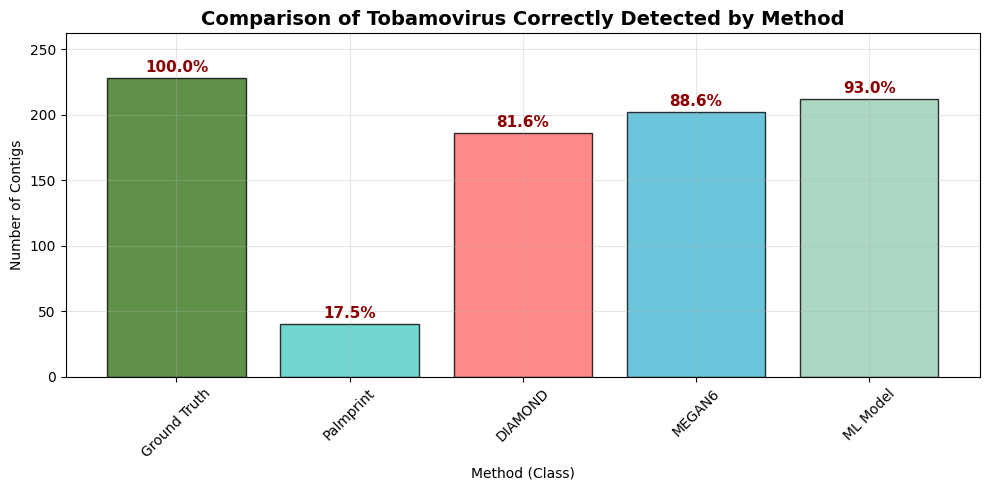

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))

columns_to_plot = ['ground_truth', 'palmprint_tobamovirus_correct', 'diamond_nr_tobamovirus_correct', 'megan_tobamovirus_correct', 'model_predictions_correct']
labels = ['Ground Truth', 'Palmprint', 'DIAMOND', 'MEGAN6', 'ML Model']
colors = ['#38761d', '#4ECDC4', '#FF6B6B', '#45B7D1', '#96CEB4']

# Show only positive class (value == 1) for each method
for i, col in enumerate(columns_to_plot):
    if 1 in gt[col].value_counts().index:
        count = gt[col].value_counts().get(1, 0)
        ax.bar(labels[i], count, color=colors[i], alpha=0.8, edgecolor='black')


# Add percentage labels on bars
counts = []
ground_truth_total = gt['ground_truth'].value_counts().get(1, 0)
for i, col in enumerate(columns_to_plot):
    count = gt[col].value_counts().get(1, 0)
    percentage = (count / ground_truth_total * 100) if ground_truth_total > 0 else 0
    ax.text(i, count + ground_truth_total * 0.01, f'{percentage:.1f}%', 
            ha='center', va='bottom', fontweight='bold', fontsize=11, color='darkred')
    counts.append(count)

ax.set_title('Comparison of Tobamovirus Correctly Detected by Method', fontsize=14, fontweight='bold')
ax.set_xlabel('Method (Class)')
ax.set_ylim(0, max(counts) * 1.15)  # Add more space above bars
ax.set_ylabel('Number of Contigs')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()


plt.show()

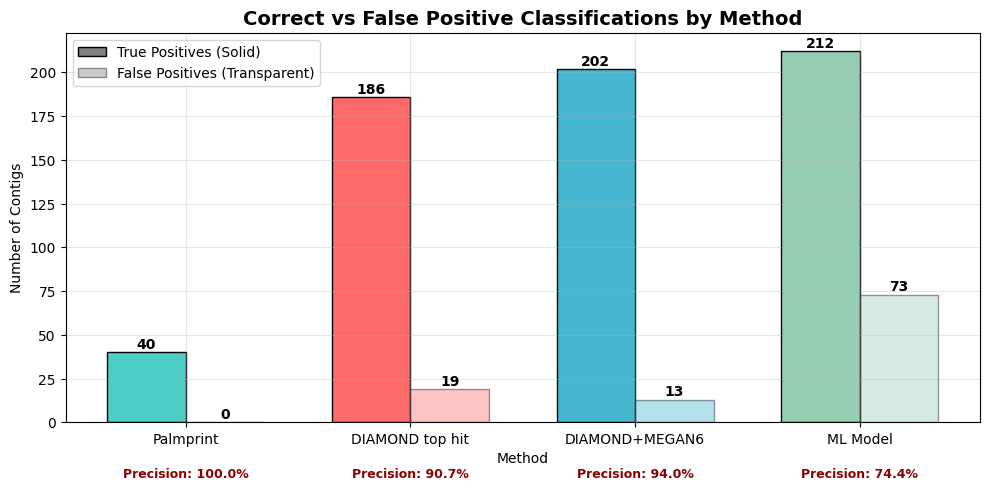

In [32]:
# Plot correct and false positives for each method

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 5))

# Define methods and their corresponding columns
methods = ['Palmprint', 'DIAMOND top hit', 'DIAMOND+MEGAN6', 'ML Model']
correct_cols = ['palmprint_tobamovirus_correct', 'diamond_nr_tobamovirus_correct', 'megan_tobamovirus_correct', 'model_predictions_correct']
false_cols = ['palmprint_tobamovirus_false', 'diamond_nr_tobamovirus_false', 'megan_tobamovirus_false', 'model_predictions_false']

# Colors for correct and false positives
colors_correct = ['#4ECDC4', '#FF6B6B', '#45B7D1', '#96CEB4']
colors_false = ['#FF7F7F', '#FFB6B6', '#87CEEB', '#C6E6C7']

# Calculate counts
correct_counts = []
false_counts = []

for correct_col, false_col in zip(correct_cols, false_cols):
    correct_count = gt[correct_col].value_counts().get(1, 0)
    false_count = gt[false_col].value_counts().get(1, 0)
    correct_counts.append(correct_count)
    false_counts.append(false_count)

# Set up bar positions
x = np.arange(len(methods))
width = 0.35

# Create grouped bars
bars1 = ax.bar(x - width/2, correct_counts, width, 
               color=colors_correct, alpha=1.0, edgecolor='black')
bars2 = ax.bar(x + width/2, false_counts, width, 
               color=colors_correct, alpha=0.4, edgecolor='black')  # Same colors but transparent

# Add value labels on bars
for i, (bar1, bar2, correct, false) in enumerate(zip(bars1, bars2, correct_counts, false_counts)):
    # Labels on correct bars
    ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.5,
            str(correct), ha='center', va='bottom', fontweight='bold')
    # Labels on false bars  
    ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.5,
            str(false), ha='center', va='bottom', fontweight='bold')
    
    # Calculate only metrics that use TP and FP
    total_positive = correct + false
    precision = (correct / total_positive * 100) if total_positive > 0 else 0
    fdr = (false / total_positive * 100) if total_positive > 0 else 0  # False Discovery Rate
    
    # Create simplified text with only TP/FP-based metrics
    metrics_text = f'Precision: {precision:.1f}%'
    ax.text(i, -max(max(correct_counts), max(false_counts)) * 0.12, 
            metrics_text, 
            ha='center', va='top', fontweight='bold', fontsize=9, color='darkred')

# Customize the plot
ax.set_title('Correct vs False Positive Classifications by Method', fontsize=14, fontweight='bold')
ax.set_xlabel('Method')
ax.set_ylabel('Number of Contigs')
ax.set_xticks(x)
ax.set_xticklabels(methods)

# Create custom legend that shows transparency difference
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gray', alpha=1.0, edgecolor='black', label='True Positives (Solid)'),
    Patch(facecolor='gray', alpha=0.4, edgecolor='black', label='False Positives (Transparent)')
]
ax.legend(handles=legend_elements)

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== TOBAMOVIRUS CATEGORY BREAKDOWN ===
tob1: 83 samples - Known tobamoviral sequences
tob2: 109 samples - Novel tobamoviral sequences
tob3: 36 samples - Difficult to assign tobamoviral sequences


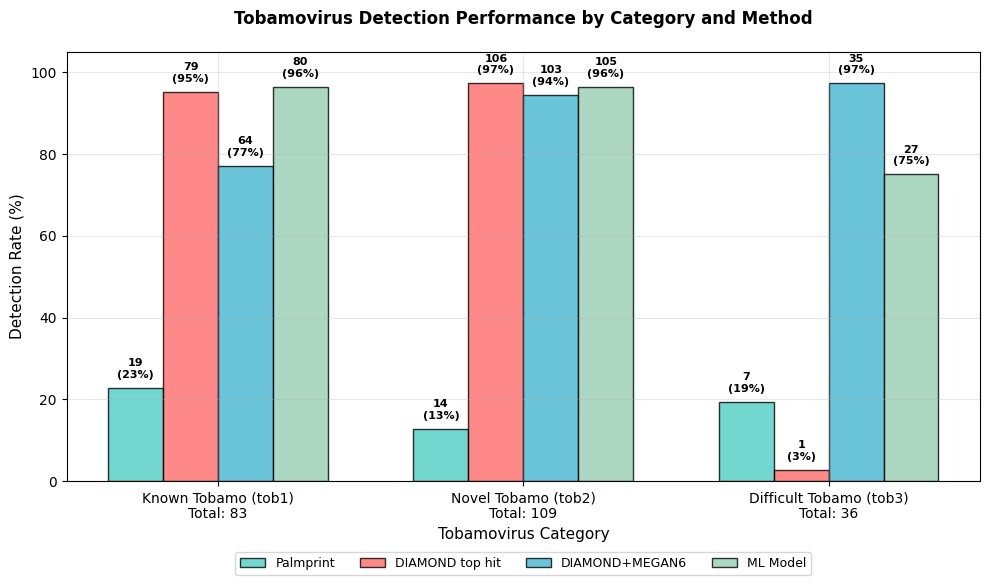

In [48]:
# Plot correct detections by tobamovirus category (tob1, tob2, tob3) for each method - Single Plot

import matplotlib.pyplot as plt
import numpy as np

# Define tobamovirus categories
tobamo_categories = ['tob1', 'tob2', 'tob3']

# Calculate totals for each category first
category_totals = {}
for cat in tobamo_categories:
    category_totals[cat] = len(gt[gt['category'] == cat])

# Create category labels with total counts
category_labels = [f'Known Tobamo (tob1)\nTotal: {category_totals["tob1"]}', 
                  f'Novel Tobamo (tob2)\nTotal: {category_totals["tob2"]}', 
                  f'Difficult Tobamo (tob3)\nTotal: {category_totals["tob3"]}']

# Define methods and colors
methods = ['Palmprint', 'DIAMOND top hit', 'DIAMOND+MEGAN6', 'ML Model']
method_columns = ['palmprint_tobamovirus_correct', 'diamond_nr_tobamovirus_correct', 
                 'megan_tobamovirus_correct', 'model_predictions_correct']
method_colors = ['#4ECDC4', '#FF6B6B', '#45B7D1', '#96CEB4']
    
print("=== TOBAMOVIRUS CATEGORY BREAKDOWN ===")
for cat, total in category_totals.items():
    cat_description = {'tob1': 'Known tobamoviral sequences', 
                      'tob2': 'Novel tobamoviral sequences', 
                      'tob3': 'Difficult to assign tobamoviral sequences'}
    print(f"{cat}: {total} samples - {cat_description.get(cat, '')}")

# Create single figure - smaller with better spacing
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate data for all methods and categories
all_data = []
method_performance = {}

for method_idx, (method, col) in enumerate(zip(methods, method_columns)):
    method_data = []
    for cat in tobamo_categories:
        cat_data = gt[gt['category'] == cat]
        if len(cat_data) > 0:
            correct_detections = cat_data[col].value_counts().get(1, 0)
            total_in_cat = len(cat_data)
            percentage = (correct_detections / total_in_cat * 100) if total_in_cat > 0 else 0
        else:
            correct_detections = 0
            percentage = 0
        method_data.append((correct_detections, percentage))
    
    method_performance[method] = method_data
    all_data.append([x[0] for x in method_data])  # Just the counts

# Set up grouped bar chart with better spacing
x = np.arange(len(tobamo_categories))  # the label locations
width = 0.18  # slightly narrower bars
multiplier = 0

# Get max value for proper padding calculations
max_value = max(max(all_data))

# Create bars for each method using percentages
for method_idx, (method, counts) in enumerate(zip(methods, all_data)):
    offset = width * multiplier
    # Get percentages for this method
    percentages = [method_performance[method][i][1] for i in range(len(tobamo_categories))]
    bars = ax.bar(x + offset, percentages, width, label=method, 
                  color=method_colors[method_idx], alpha=0.8, edgecolor='black')
    
    # Add value labels on bars with better spacing
    for i, (bar, count) in enumerate(zip(bars, counts)):
        percentage = method_performance[method][i][1]
        # Add more padding above bars to prevent overlap
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100 * 0.02,
                f'{count}\n({percentage:.0f}%)', ha='center', va='bottom', 
                fontweight='bold', fontsize=8)
    
    multiplier += 1

# Customize the plot with better spacing
ax.set_title('Tobamovirus Detection Performance by Category and Method', 
             fontsize=12, fontweight='bold', pad=20)
ax.set_xlabel('Tobamovirus Category', fontsize=11)
ax.set_ylabel('Detection Rate (%)', fontsize=11)
ax.set_ylim(0, 105)  # Set to 0-105% for percentage scale
ax.set_xticks(x + width * 1.5)  # Center the x-tick labels
ax.set_xticklabels(category_labels, fontsize=10)
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, fontsize=9)
ax.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()